# Домашняя работа (решающее дерево)

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [103]:
from sklearn import datasets
from sklearn import model_selection
import numpy as np

In [104]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [105]:
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        pass

In [106]:
class ClassificationLeaf(Leaf):
    def __init__(self, data, labels):
        super(ClassificationLeaf, self).__init__(data, labels)

    def predict(self):
        classes = get_count_label(self.labels)
        prediction = max(classes, key=classes.get)
        return prediction

In [107]:
def get_count_label(labels):
    total_count_classes = np.unique(labels)
    classes = {}
    for class_ in total_count_classes:
        classes[class_] = len(labels[labels == class_])
    return classes

In [108]:
class Quality:
    def __init__(self, inform_criterion_method='gini'):
        if inform_criterion_method == 'gini':
            self.inform_criterion_method = self.gini

    # Расчет качества
    def quality(self, left_labels: np.array, right_labels: np.array, current_information_criterion: float):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_information_criterion - p * self.inform_criterion_method(left_labels) - \
               (1 - p) * self.inform_criterion_method(right_labels)

    def gini(cls, labels):
        #  подсчет количества объектов разных классов
        classes = get_count_label(labels)

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

In [109]:
class DecisionTree:
    def __init__(self, quality: Quality, min_leaf: int = 5, max_count_features=None, max_depth=None, max_leaves=None):
        self.features = list()
        self.min_leaf = min_leaf
        self.quality = quality
        self.tree = None
        self.max_count_features = max_count_features
        self.max_depth = max_depth
        self.max_leaf = max_leaves
        self.leaves_increase = 2
        self.ClassLeaf = None

    # Разбиение датасета в узле
    @staticmethod
    def __split(data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def __find_best_split(self, data, labels):
        current_info_criterion = self.quality.inform_criterion_method(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.__split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality.quality(true_labels, false_labels, current_info_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def __build_tree(self, data, labels, depth=0):
        quality, t, index = self.__find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return self.ClassLeaf(data, labels)

        # Случай превышения максимального количества использованных фитчей
        self.features.append(index)
        if self.max_count_features and self.max_count_features < len(self.features):
            return self.ClassLeaf(data, labels)

        # Случай превышения максимального количества листьев в дереве
        if self.max_leaf and self.max_leaf <= self.count_leafes:
            return self.ClassLeaf(data, labels)

        # Случай превышения максимальной глубины
        if self.max_depth and self.max_depth <= depth:
            return self.ClassLeaf(data, labels)

        # узел не стал листом
        self.count_leafes -= 1
        true_data, false_data, true_labels, false_labels = self.__split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        self.count_leafes += self.leaves_increase
        true_branch = self.__build_tree(true_data, true_labels, depth=depth + 1)
        self.count_leafes += self.leaves_increase
        false_branch = self.__build_tree(false_data, false_labels, depth=depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def fit(self, data, labels):
        self.features = list()
        self.count_leafes = 2
        self.tree = self.__build_tree(data, labels)

    def __predict_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.ClassLeaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.__predict_object(obj, node.true_branch)
        else:
            return self.__predict_object(obj, node.false_branch)

    def predict(self, data):
        answers = []
        for obj in data:
            prediction = self.__predict_object(obj, self.tree)
            answers.append(prediction)
        return np.array(answers)

In [110]:
class DecisionTreeClassification(DecisionTree):
    def __init__(self, quality: Quality, min_leaf: int = 5, max_count_features=None, max_depth=None, max_leaves=None):
        super().__init__(quality, min_leaf, max_count_features, max_depth, max_leaves)
        self.ClassLeaf = ClassificationLeaf

Проверка: 

In [111]:
def accuracy(y: np.array, y_pred: np.array) -> float:
    return y[y == y_pred].shape[0] / y.shape[0]

In [112]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features=7, n_informative=7,
                                                                          n_classes=2, n_redundant=0,
                                                                          n_clusters_per_class=1, random_state=17)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)


In [113]:
model = DecisionTreeClassification(
        Quality(inform_criterion_method='gini')
    )
model.fit(train_data, train_labels)
accuracy(train_labels, model.predict(train_data))

0.9385714285714286

In [114]:
model = DecisionTreeClassification(
        Quality(inform_criterion_method='gini'),
        max_depth=2
    )
model.fit(train_data, train_labels)
accuracy(train_labels, model.predict(train_data))

0.74

In [115]:
model = DecisionTreeClassification(
        Quality(inform_criterion_method='gini'),
        max_count_features=5
    )
model.fit(train_data, train_labels)
accuracy(train_labels, model.predict(train_data))

0.7585714285714286

In [116]:
model = DecisionTreeClassification(
        Quality(inform_criterion_method='gini'),
        max_leaves=3
    )
model.fit(train_data, train_labels)
accuracy(train_labels, model.predict(train_data))

0.7328571428571429

### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

Перепишем класс Quality

In [117]:
class Quality:
    def __init__(self, inform_criterion_method='gini'):
        if inform_criterion_method == 'gini':
            self.inform_criterion_method = self.gini
        if inform_criterion_method == 'entropy':
            self.inform_criterion_method = self.entropy

    # Расчет качества
    def quality(self, left_labels: np.array, right_labels: np.array, current_information_criterion: float):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_information_criterion - p * self.inform_criterion_method(left_labels) - \
               (1 - p) * self.inform_criterion_method(right_labels)

    def gini(cls, labels):
        #  подсчет количества объектов разных классов
        classes = get_count_label(labels)

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

    def entropy(cls, labels):
        classes = get_count_label(labels)

        result = 0
        for label in classes:
            p = classes[label] / len(labels)
            result += p * np.log2(p)

        return -result

Для начала проведем анализ результатов без использования регуляризации 

In [118]:
gini_model = DecisionTreeClassification(
        Quality(inform_criterion_method='gini'))
gini_model.fit(train_data, train_labels)
print(f'gini train = {accuracy(train_labels, gini_model.predict(train_data))}')
print(f'gini test = {accuracy(test_labels, gini_model.predict(test_data))}')

print('\n')

entropy_model = DecisionTreeClassification(
    Quality(inform_criterion_method='entropy'))
entropy_model.fit(train_data, train_labels)
print(f'entropy train = {accuracy(train_labels, entropy_model.predict(train_data))}')
print(f'entropy test = {accuracy(test_labels, entropy_model.predict(test_data))}')

gini train = 0.9385714285714286
gini test = 0.9033333333333333


entropy train = 0.9542857142857143
entropy test = 0.8933333333333333


Видно, что на train модель с использованием критерия информативности Энтропия лучше, однако на test модель с критерием информативности Джини, показывает себя лучше. Теперь сделаем аналогичный анализ, только с использованием регуляризации

In [119]:
gini_model = DecisionTreeClassification(
        Quality(inform_criterion_method='gini'), max_depth=4, max_leaves=4)
gini_model.fit(train_data, train_labels)
print(f'gini train = {accuracy(train_labels, gini_model.predict(train_data))}')
print(f'gini test = {accuracy(test_labels, gini_model.predict(test_data))}')

print('\n')

entropy_model = DecisionTreeClassification(
    Quality(inform_criterion_method='entropy'), max_depth=4, max_leaves=4)
entropy_model.fit(train_data, train_labels)
print(f'entropy train = {accuracy(train_labels, entropy_model.predict(train_data))}')
print(f'entropy test = {accuracy(test_labels, entropy_model.predict(test_data))}')

gini train = 0.74
gini test = 0.7533333333333333


entropy train = 0.7242857142857143
entropy test = 0.7333333333333333


Видно, что при использовании регуляризации модель на основании критерия Джини ведет себя лучше

### 3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

Для решения этой задачи нужно создать класс RegressionLeaf, унаследовав его от Leaf

In [120]:
class RegressionLeaf(Leaf):
    def __init__(self, data, labels):
        super(RegressionLeaf, self).__init__(data, labels)

    def predict(self):
        return np.mean(self.labels)

Добавить новый информационный критерий "дисперсия" в класс Quality

In [121]:
class Quality:
    def __init__(self, inform_criterion_method='gini'):
        if inform_criterion_method == 'gini':
            self.inform_criterion_method = self.gini
        if inform_criterion_method == 'entropy':
            self.inform_criterion_method = self.entropy
        if inform_criterion_method == 'variance':
            self.inform_criterion_method = self.variance


    # Расчет качества
    def quality(self, left_labels: np.array, right_labels: np.array, current_information_criterion: float):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_information_criterion - p * self.inform_criterion_method(left_labels) - \
               (1 - p) * self.inform_criterion_method(right_labels)

    def gini(cls, labels):
        #  подсчет количества объектов разных классов
        classes = get_count_label(labels)

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

    def entropy(cls, labels):
        classes = get_count_label(labels)

        result = 0
        for label in classes:
            p = classes[label] / len(labels)
            result += p * np.log2(p)

        return -result

    def variance(cls, labels):
        return np.var(labels)

И, наконец, создать класс DecisionTreeRegression унаследовав его от DecisionTree

In [122]:
class DecisionTreeRegression(DecisionTree):
    def __init__(self, quality: Quality, min_leaf: int = 2, max_count_features=None, max_depth=None, max_leaves=None):
        super(DecisionTreeRegression, self).__init__(quality, min_leaf, max_count_features, max_depth, max_leaves)
        self.ClassLeaf = RegressionLeaf

In [123]:
regression_data, regression_labels, coef = datasets.make_regression(n_samples=1000, 
                                                              n_features=1, 
                                                              n_informative=1, 
                                                              n_targets=1, 
                                                              noise=5, 
                                                              coef=True, 
                                                              random_state=17)


train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data,
                                                                                    regression_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)
model = DecisionTreeRegression(Quality(inform_criterion_method='variance'), 
                               min_leaf=10, 
                               max_depth=6)
model.fit(train_data, train_labels)


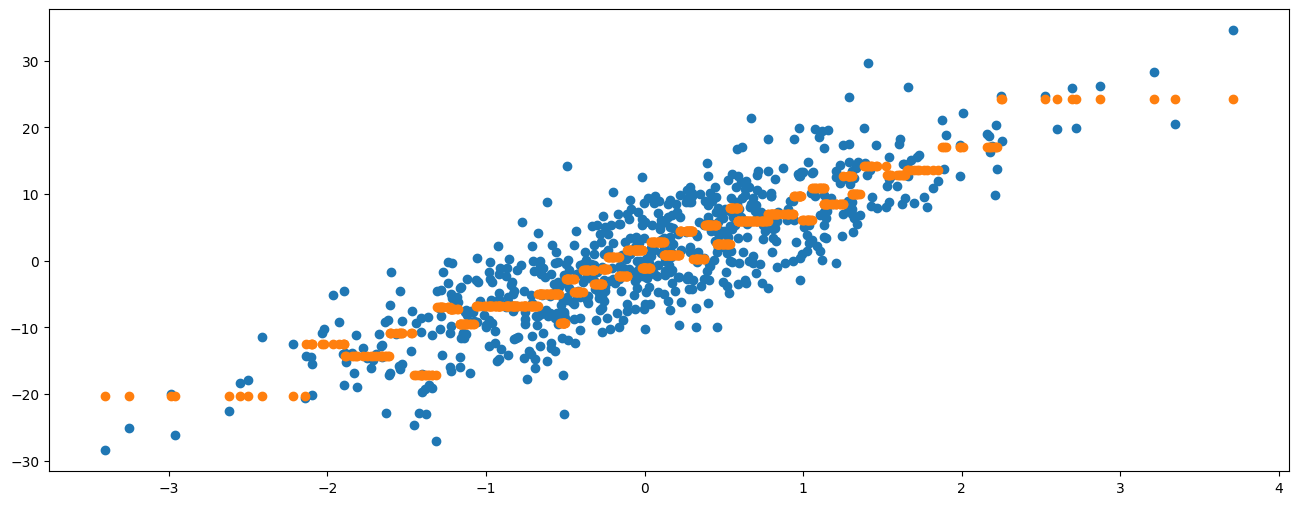

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.scatter(train_data, train_labels)
plt.scatter(train_data, model.predict(train_data))
plt.show()

На картинке отчетливо видны листья дерева